## Configuro notebook

In [35]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Importo librerias

In [36]:
import pandas as pd 
import numpy as np
import chardet
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

## Extraigo datos y visualizo

In [37]:
nombre_archivo = DATOS_DIR + 'creditcard.csv'

# carga archivo de datos. No tiene fila con titulos!
df= pd.read_csv(nombre_archivo)

display(df.head())

resultados = df.iloc[:,-1].value_counts(sort=True)
display(resultados)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64

## Class 1 ==> Fraudulenta

## Visualizo distribucion de los datos

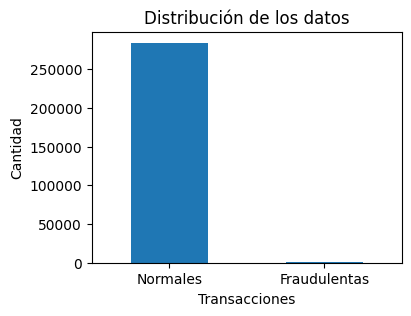

In [38]:
# Cantidad de registros normales vs. fraudulentos
plt.figure(figsize=(4,3))
resultados.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentas'])
plt.title("Distribución de los datos")
plt.xlabel("Transacciones")
plt.ylabel("Cantidad")
plt.show()

## Visualizo transacciones respecto del tiempo

Cantidad de normales:  284315
Cantidad de fraudulentos:  492


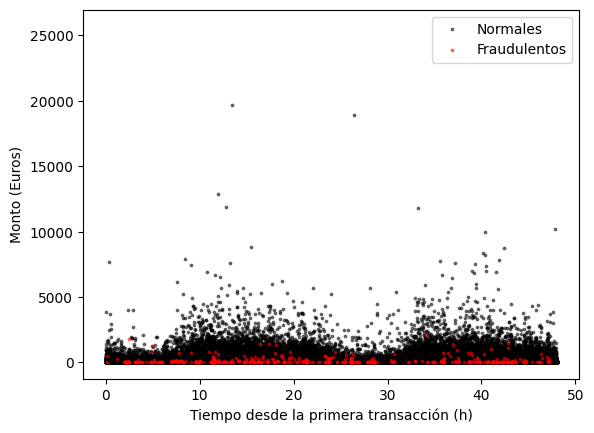

In [39]:
normales = df[df.Class==0]
fraudulentos = df[df.Class==1]

print('Cantidad de normales: ', len(normales))
print('Cantidad de fraudulentos: ', len(fraudulentos))

plt.scatter(normales.Time/3600, normales.Amount, alpha = 0.5, c='k', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, alpha = 0.5, c='r', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()

## Visualizo transacciones respecto del monto

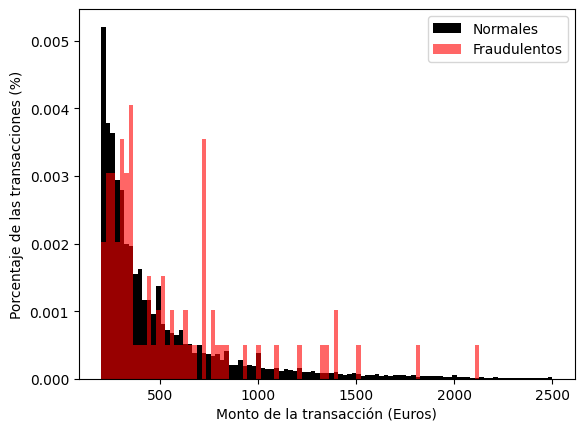

In [40]:
bins = np.linspace(200, 2500, 100)
plt.hist(normales.Amount, bins, alpha=1, density=True, label='Normales', color='k')
plt.hist(fraudulentos.Amount, bins, alpha=0.6, density=True, label='Fraudulentos', color='r')
plt.legend(loc='upper right')
plt.xlabel("Monto de la transacción (Euros)")
plt.ylabel("Porcentaje de las transacciones (%)")
plt.show()

## Como en los graficos vimos que las transacciones fraudulentas no dependen del tiempo, extraigo esos valores

In [41]:
df.drop(['Time'], axis=1, inplace=True)

## Preparo y normalizo datos

In [42]:
# separa en etiquetas y datos
FEAT_CNT = df.shape[1] - 1

raw_data = df.values

labels = raw_data[:, -1]    # Etiquetas (última columna)
data = raw_data[:, 0:-1]  # Datos 


# separa en datos de entrenamiento y testeo
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=1
)

# Normalización de datos entre 0 y 1. Los datos son lecturas de una señal acotada en intensidad
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

normal_train_data = train_data[train_labels == 0]
normal_test_data = test_data[test_labels == 0]

anomal_train_data = train_data[train_labels == 1]
anomal_test_data = test_data[test_labels == 1]

## Construyo modelo

In [44]:
# codificador
encoder = tf.keras.Sequential([
    layers.Dense(20, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu")],
    name = 'Encoder'
    )

# decodificador
decoder = tf.keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(20, activation="relu"),
    layers.Dense(FEAT_CNT, activation="sigmoid")],
    name = 'Decoder'
    )

# Modelo completo del autoencoder
# observar como se encadenan la entrada con el codificador y el codificador con el decodificador
inputs = tf.keras.Input(shape=(FEAT_CNT,))
encoded = encoder(inputs)
decoded = decoder(encoded)

# Modelo que tiene dos modelos en secuencia
autoencoder = tf.keras.Model(inputs=inputs, outputs=decoded, name = 'Autoencoder')

from keras.optimizers import SGD
sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 20)                600       
                                                                 
 dense_55 (Dense)            (None, 16)                336       
                                                                 
 dense_56 (Dense)            (None, 8)                 136       
                                                                 
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________
None
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 16)                144       
                                                                 
 dense_58 (Dense)            (None,

## Entreno

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = autoencoder.fit(normal_train_data, normal_train_data,
    epochs=200, batch_size=128, validation_data=(test_data, test_data),
    shuffle=True
    )

Epoch 1/200
1777/1777 [==============================] - 5s 3ms/step - loss: 1.1352 - val_loss: 1.0334
Epoch 2/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9674 - val_loss: 0.9809
Epoch 3/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9570 - val_loss: 0.9791
Epoch 4/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9555 - val_loss: 0.9778
Epoch 5/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9543 - val_loss: 0.9765
Epoch 6/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9530 - val_loss: 0.9752
Epoch 7/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9517 - val_loss: 0.9738
Epoch 8/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9501 - val_loss: 0.9720
Epoch 9/200
1777/1777 [==============================] - 4s 2ms/step - loss: 0.9481 - val_loss: 0.9696
Epoch 10/200
1777/1777 [==============================] - 4s 2ms/step - l

## Visualizo loss

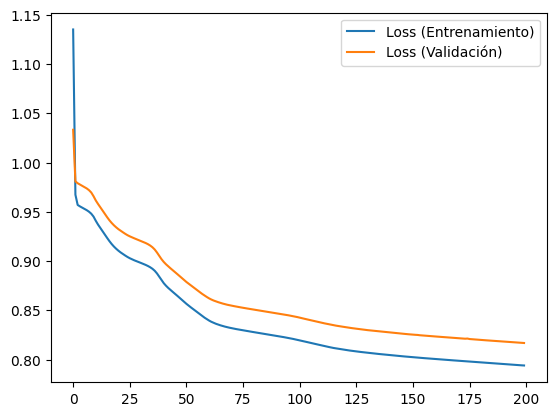

In [46]:
######## plot
plt.figure()
plt.plot(history.history["loss"], label="Loss (Entrenamiento)")
plt.plot(history.history["val_loss"], label="Loss (Validación)")
plt.legend()

## Error de construccion en transacciones normales

7108/7108 [==============================] - 6s 889us/step


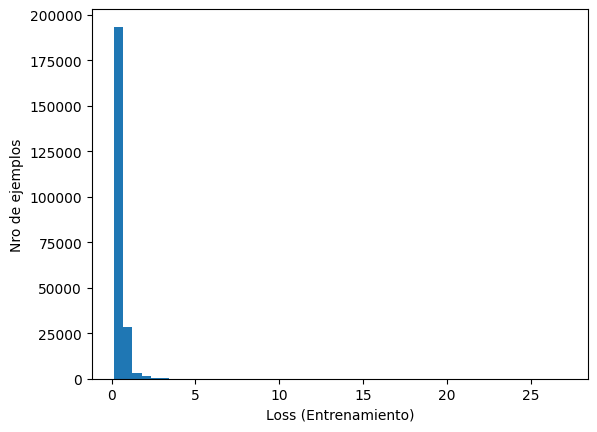

In [47]:
#Trazar el error de reconstrucción en ECG normales del conjunto de entrenamiento
reconstruccion = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruccion, normal_train_data)

plt.figure()
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Loss (Entrenamiento)")
plt.ylabel("Nro de ejemplos")
plt.show()

## Error (pérdida) de reconstrucción en transacciones fraudulentas del conjunto de prueba

3/3 [==============================] - 0s 1ms/step


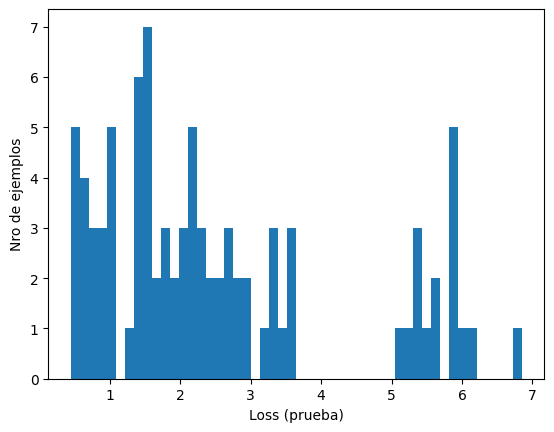

In [48]:
reconstruccion = autoencoder.predict(anomal_test_data)
test_loss = tf.keras.losses.mae(reconstruccion, anomal_test_data)

plt.figure()
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Loss (prueba)")
plt.ylabel("Nro de ejemplos")
plt.show()


In [49]:
def predict(modelo, datos, umbral):
  reconstruccion = modelo(datos)
  loss = tf.keras.losses.mae(reconstruccion, datos)
  return tf.math.less(loss, umbral)

def print_stats(predicciones, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predicciones)))
  print("Precision = {}".format(precision_score(labels, predicciones)))
  print("Recall = {}".format(recall_score(labels, predicciones)))


# Elija un valor de umbral que sea una desviación estándar por encima de la media.
#threshold = np.mean(train_loss) + np.std(train_loss)
umbral = np.mean(train_loss) + 1.5*np.std(train_loss)
print("Umbral: ", umbral)

# Al examinar el error de reconstrucción de los ejemplos anómalos en el conjunto de prueba, se observa
# que la mayoría tiene un error de reconstrucción mayor que el umbral. Al variar el umbral, puede
# ajustar la "precision" y el "recall".

# evalua los datos de prueba con las reconstrucciones, mide error y aplica umbral
preds = predict(autoencoder, test_data, umbral)
# imprime estadisticas en función del umbral aplicado
print_stats(preds, test_labels)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels, preds)  # Asegúrate de que `preds` tenga el mismo tamaño que `test_labels`
print("Matriz de Confusión:\n", conf_matrix)

# Generar el reporte de clasificación
report = classification_report(test_labels, preds)
print("Reporte de Clasificación:\n", report)

Umbral:  1.027930589759015
Accuracy = 0.04109757382114392
Precision = 0.0003481638935717951
Recall = 0.21839080459770116
Matriz de Confusión:
 [[ 2322 54553]
 [   68    19]]
Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.97      0.04      0.08     56875
         1.0       0.00      0.22      0.00        87

    accuracy                           0.04     56962
   macro avg       0.49      0.13      0.04     56962
weighted avg       0.97      0.04      0.08     56962



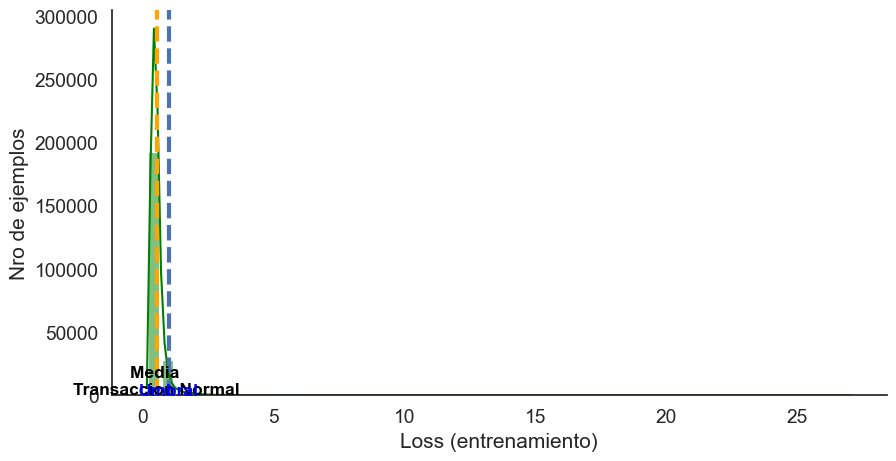

In [50]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.25)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='green',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='orange', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 370, "Media \nTransaccion Normal", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.text(umbral, 250, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.xlabel("Loss (entrenamiento)")
plt.ylabel("Nro de ejemplos")
sns.despine()

3/3 [==============================] - 0s 1ms/step


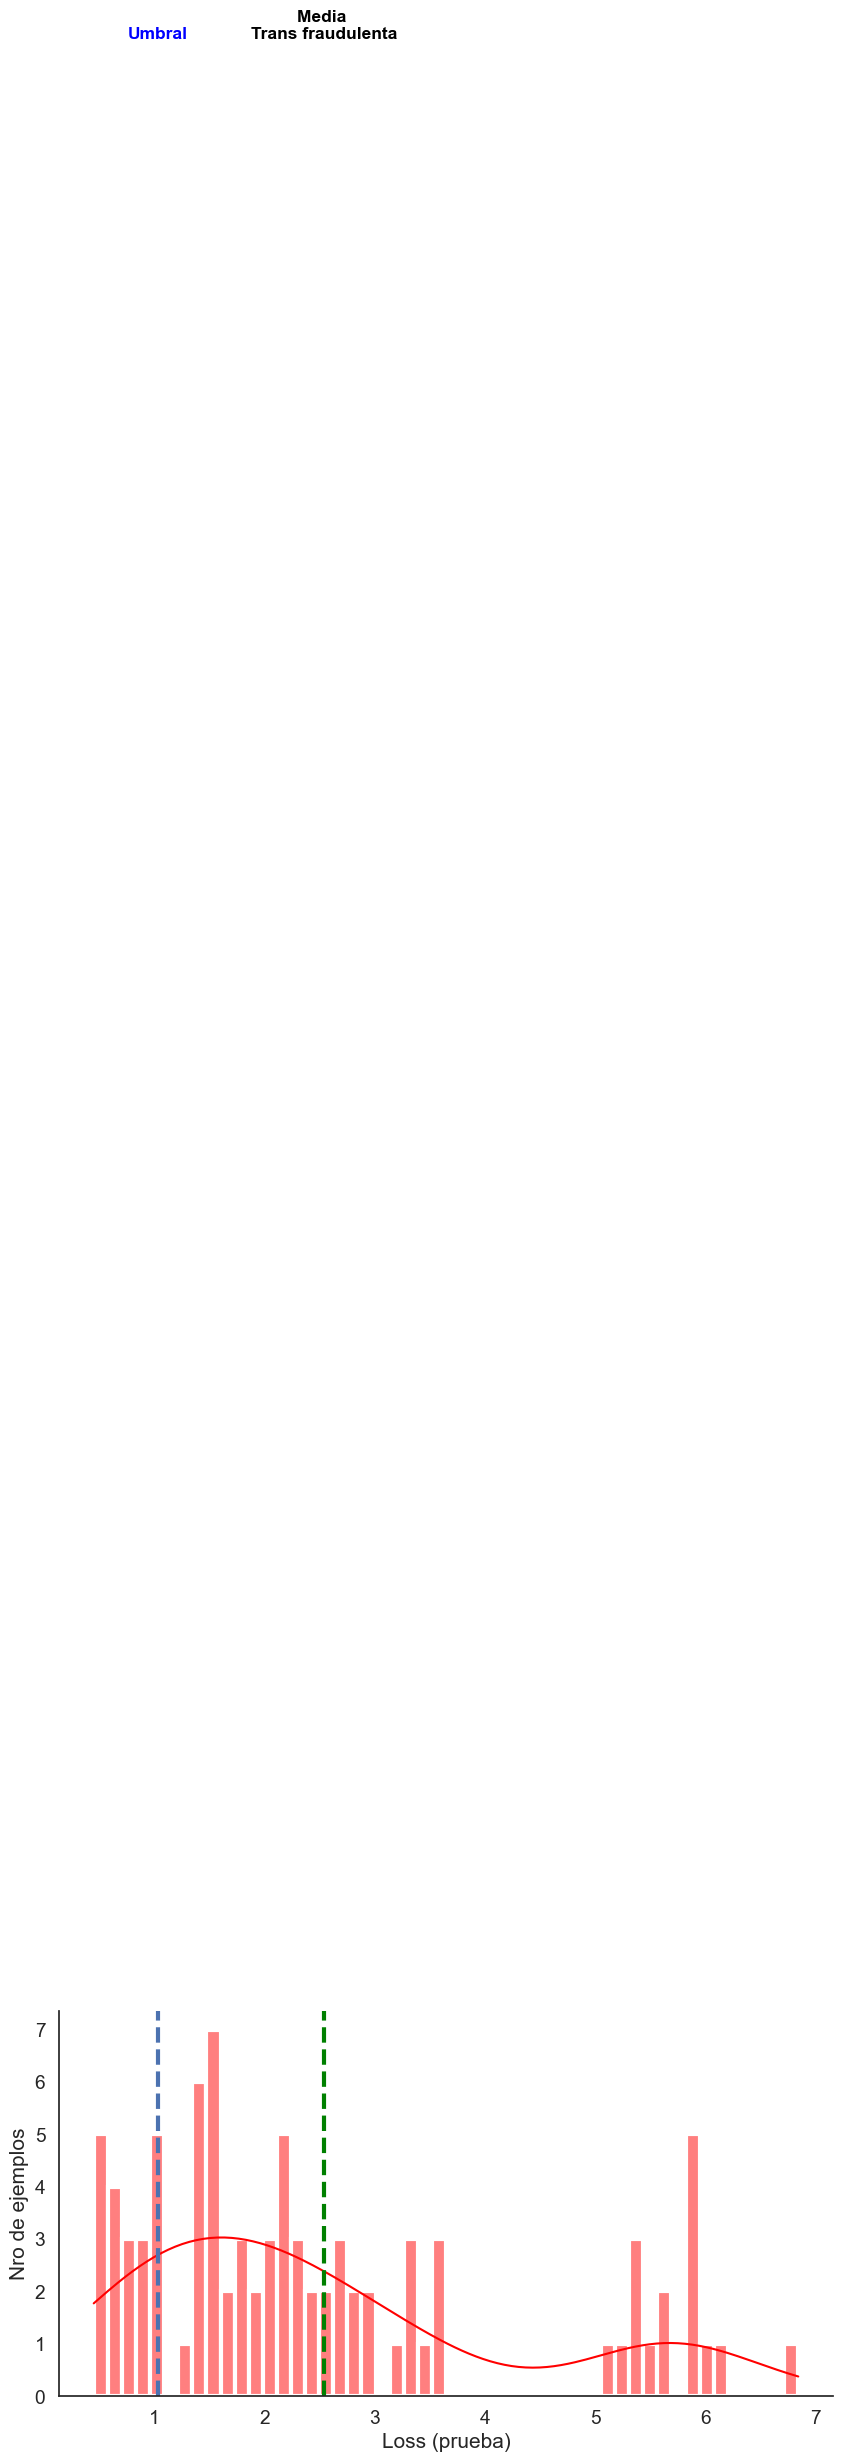

In [58]:
reconstruccion = autoencoder.predict(anomal_test_data)
test_loss = tf.keras.losses.mae(reconstruccion, anomal_test_data)

plt.figure(figsize=(10,5))
sns.set(font_scale = 1.25)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='green', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 45, "Media \nTrans fraudulenta", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.text(umbral, 45, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.xlabel("Loss (prueba)")
plt.ylabel("Nro de ejemplos")
sns.despine()